# Human Remover project for the ISD for collage

## 1. Problem

Identifing if the person is Male OR Female

## 2. Data

The data is from Kaggle
link: https://www.kaggle.com/datasets/yasserhessein/gender-dataset

## 3. Goal

To have 90+% accuracy

## 4. Features

Some information about the data:
* we're dealing with images (unsturctured data), so I'll have to use Deep Learning model
* There are 2 classes ( Male | Female), so it's binary classification
* There are 92.8k files for F, 67.2k for M in the Train file (160k)
* There are 11.5k files for F, 8.5k for M in the Test file (20k)
* There are 13.8k files for F, 8.8k for M in the Validation file (22.6k)

In [1]:
# Importing necessary tools
import os
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from IPython.display import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

In [2]:
# check for GPU if available
print("GPU", "available (YESSS!!!!)" if tf.config.list_physical_devices("GPU") else "not available")

GPU available (YESSS!!!!)


## Getting our data ready:

In [3]:
# Creating variables: 
batch_size = 64
seed=1337
target_size = (150, 150)
epochs=10


In [4]:
data_generator = ImageDataGenerator( rescale = 1.0/255)

train_generator = data_generator.flow_from_directory('../input/gender-dataset/Dataset/Train',
                                                    batch_size =batch_size ,
                                                    class_mode = 'binary',
                                                    seed=seed,
                                                    target_size = target_size )     

validation_generator =  data_generator.flow_from_directory( '../input/gender-dataset/Dataset/Validation',
                                                          batch_size  = batch_size,
                                                          class_mode  = 'binary',
                                                          seed=seed,
                                                          target_size = target_size)

Found 160000 images belonging to 2 classes.
Found 22598 images belonging to 2 classes.


In [12]:
test_generator = data_generator.flow_from_directory('../input/gender-dataset/Dataset/Test',
                                                    batch_size =batch_size ,
                                                    class_mode = 'binary',
                                                    seed=seed,
                                                    target_size = target_size )

Found 20001 images belonging to 2 classes.


In [5]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',
                        patience = 3,
                        verbose = 1 ,
                        factor = 0.5,
                        min_lr = 0.0001)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=3)

In [6]:
# Setting up the variables
img_size = 244
input_shape = [None, img_size, img_size, 3] # [batch, height, width, colorChannels(dimensions)]
output_shape = 1 # Male | Female
model_URL = "https://www.kaggle.com/models/google/efficientnet-v2/TensorFlow2/imagenet1k-b1-classification/2"
# Model source: https://www.kaggle.com/models/google/efficientnet-v2

In [7]:
# Creating a fxn which builds a Keras model
def create_model(input_shape=input_shape, output_shape=output_shape, model_url=model_URL):
    # Set up the model layers
    model = tf.keras.Sequential([
        hub.KerasLayer(model_URL), # Layer 1 (input layer)
        tf.keras.layers.Dense(units=output_shape,
                       activation="sigmoid") # Layer 2 (output layer)
    ])
    # Compile the model
    model.compile(
        loss='binary_crossentropy',
        optimizer= tf.keras.optimizers.Adam(),
        metrics= ["accuracy"]
    )
    # Build the model
    model.build(input_shape)
    
    return model

In [8]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1000)              8212124   
_________________________________________________________________
dense (Dense)                (None, 1)                 1001      
Total params: 8,213,125
Trainable params: 1,001
Non-trainable params: 8,212,124
_________________________________________________________________


In [9]:
model.fit_generator(generator=train_generator,
                           validation_data=validation_generator,
                           steps_per_epoch=256,
                           validation_steps=256,
                           epochs=epochs,
                           callbacks=[lrd, mcp, es])

Epoch 1/10
256/256 [==============================] - 318s 1s/step - loss: 0.2330 - accuracy: 0.9026 - val_loss: 0.2278 - val_accuracy: 0.9073
Epoch 2/10
256/256 [==============================] - 239s 932ms/step - loss: 0.1980 - accuracy: 0.9226 - val_loss: 0.1888 - val_accuracy: 0.9247
Epoch 3/10
256/256 [==============================] - 196s 764ms/step - loss: 0.1867 - accuracy: 0.9263 - val_loss: 0.1872 - val_accuracy: 0.9277
Epoch 4/10
256/256 [==============================] - 164s 642ms/step - loss: 0.1809 - accuracy: 0.9279 - val_loss: 0.1839 - val_accuracy: 0.9299
Epoch 5/10
256/256 [==============================] - 158s 618ms/step - loss: 0.1775 - accuracy: 0.9291 - val_loss: 0.1778 - val_accuracy: 0.9301
Epoch 6/10
256/256 [==============================] - 151s 590ms/step - loss: 0.1772 - accuracy: 0.9317 - val_loss: 0.1910 - val_accuracy: 0.9276
Epoch 7/10
256/256 [==============================] - 137s 535ms/step - loss: 0.1795 - accuracy: 0.9293 - val_loss: 0.1799 - va

In [20]:
evaluation = model.evaluate_generator(test_generator)

print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

Test Loss: 0.15593096613883972
Test Accuracy: 0.937153160572052


example on the 7% error:

[0.42947504]
This is a male


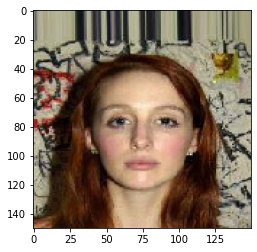

In [32]:
import numpy as np

from keras.preprocessing import image
#  images test 1
path_testmodel = "/kaggle/input/gender-dataset/Dataset/Test/Female/160016.jpg"
path_testmodel2 = "/kaggle/input/gender-dataset/Dataset/Test/Male/160015.jpg"
imge = image.load_img(path_testmodel, target_size=target_size)
X = image.img_to_array(imge)
X = np.expand_dims(X, axis=0)

images = np.vstack([X])
classes = model.predict(images, batch_size=1)
print(classes[0])
if classes[0]<0.5:
    print("This is a male")
else:
    print( "This  is a female")
plt.imshow(imge)

[1.]
This  is a female


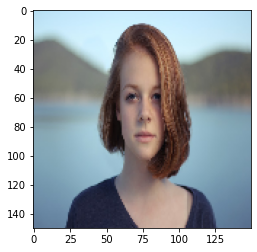

In [37]:
import numpy as np

from keras.preprocessing import image
#  images test 1
path_testmodel = "../input/testmodel/test1.jpg"
imge = image.load_img(path_testmodel, target_size=target_size)
X = image.img_to_array(imge)
X = np.expand_dims(X, axis=0)

images = np.vstack([X])
classes = model.predict(images, batch_size=1)
print(classes[0])
if classes[0]<0.5:
    print("This is a male")
else:
    print( "This  is a female")
plt.imshow(imge)

[0.00031599]
This is a male


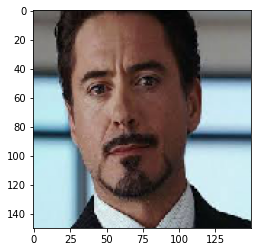

In [11]:
import numpy as np

from keras.preprocessing import image
#  images test 1
path_testmodel = "../input/testmodel/test2.jpg"
imge = image.load_img(path_testmodel, target_size=target_size)
X = image.img_to_array(imge)
X = np.expand_dims(X, axis=0)

images = np.vstack([X])
classes = model.predict(images, batch_size=1)
print(classes[0])
if classes[0]<0.5:
    print("This is a male")
else:
    print( "This  is a female")
plt.imshow(imge)